In [1]:
import tushare as ts
import baostock as bs
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
ts.set_token('') # token需要自己注册获得
get_data = ts.pro_api()
lg = bs.login()
print('login respond error_code:'+lg.error_code)# 显示登陆返回信息
print('login respond  error_msg:'+lg.error_msg)

path = 'data/'
stocks_path = 'data/stocks/'
results_path = 'data/results/'
trading_stocks_list_path = "data/trading_stocks_list/"
adjust_path = "data/adjust/" # 复权因子

login success!
login respond error_code:0
login respond  error_msg:success


# 下载 + 保存 数据
先找硬盘，没有再下载

In [3]:
def get_trade_calendar(file_name = "trade_cal_1990-2021.csv", start_date = "19901219", end_date = "", exchange = 'SSE'): # 获得交易日日历；start_date, end_date 是字符串
    names = os.listdir(path)
    if file_name in names: # 从保存的文件读入
        trade_cal = pd.read_csv(path + file_name, index_col = 'cal_date')
        trade_cal.index = pd.to_datetime(trade_cal.index) # 索引变成日期类型
    else: 
        trade_cal = get_data.trade_cal(exchange = exchange, start_date = start_date, end_date = end_date)
        trade_cal['cal_date'] = pd.to_datetime(trade_cal['cal_date']) # 日期字符串转换成日期类型
        trade_cal = trade_cal.set_index(keys='cal_date') .drop(['exchange'], axis=1)
        trade_cal.to_csv(path + file_name) # 保存, 只是一个缓存，每次使用下载功能时，会覆盖前面的内容
    return trade_cal

def get_index_daily(file_name = "index_daily_SH.csv", start = '1990-12-19', end = ''): # 爬网易，得到上证指数
    names = os.listdir(path)
    if file_name in names: # 如果已经下载过
        index_daily = pd.read_csv(path + file_name, index_col = 'date') # 读一遍
        index_daily.index = pd.to_datetime(index_daily.index)
        if index_daily.index[-1].date() < datetime.now().date(): # 下载不在文件的日期
            if datetime.now().hour >= 17: # 当天是数据必须在1700之后下载
                start = (index_daily.index[-1].date() + timedelta(days=1)).strftime('%Y-%m-%d')
                end = datetime.now().date().strftime('%Y-%m-%d')
                if start <= end:
                    rs = bs.query_history_k_data_plus("sh.000001","date,close,high,low,open,preclose,pctChg,volume,amount",start_date = start, end_date = end, frequency="d")
                    data_list = []
                    while (rs.error_code == '0') & rs.next():# 获取一条记录，将记录合并在一起
                        data_list.append(rs.get_row_data())
                    new_index_daily = pd.DataFrame(data_list, columns = rs.fields).set_index(keys='date')
                    new_index_daily = new_index_daily.sort_index()
                    index_daily = pd.concat([index_daily,new_index_daily]) # 默认沿axis=0，join=‘out’ 新旧数据拼接
            else:
                start = (index_daily.index[-1].date() + timedelta(days=1)).strftime('%Y-%m-%d')
                end = (datetime.now().date() - timedelta(days=1)).strftime('%Y-%m-%d')
                if start < end:
                    rs = bs.query_history_k_data_plus("sh.000001","date,close,high,low,open,preclose,pctChg,volume,amount",start_date = start, end_date = end, frequency="d")
                    data_list = []
                    while (rs.error_code == '0') & rs.next():# 获取一条记录，将记录合并在一起
                        data_list.append(rs.get_row_data())
                    new_index_daily = pd.DataFrame(data_list, columns = rs.fields).set_index(keys='date')
                    new_index_daily = new_index_daily.sort_index()
                    index_daily = pd.concat([index_daily,new_index_daily]) # 默认沿axis=0，join=‘out’ 新旧数据拼接
            index_daily.to_csv(path + file_name)
    else:
        rs = bs.query_history_k_data_plus("sh.000001","date,close,high,low,open,preclose,pctChg,volume,amount",start_date = start, end_date = end, frequency="d")
        data_list = []
        while (rs.error_code == '0') & rs.next():# 获取一条记录，将记录合并在一起
            data_list.append(rs.get_row_data())
        index_daily = pd.DataFrame(data_list, columns = rs.fields).set_index(keys='date')
        index_daily = index_daily.sort_index()
        index_daily.to_csv(path + file_name)
    return index_daily

def save_stock_data(date, trade_cal): # 保存一天的个股日线
    if date < trade_cal.index[0] or date > datetime.now(): # 检查输入的日期是否正确
        raise ValueError("日期错误")
    if trade_cal.loc[date][0]:
        if date.date() < datetime.now().date(): # 当天之前的直接下载保存
            stock_data = get_data.daily(trade_date = date.strftime('%Y%m%d')).drop(['trade_date', 'pre_close', 'vol'], axis = 1).set_index(keys='ts_code')
            stock_data.to_csv(stocks_path + date.strftime('%Y%m%d') + ".csv")
        else: 
            if datetime.now().hour >= 17: # 当天是数据必须在1700之后下载
                stock_data = get_data.daily(trade_date = date.strftime('%Y%m%d')).drop(['trade_date', 'pre_close', 'vol'], axis = 1).set_index(keys='ts_code')
                stock_data.to_csv(stocks_path + date.strftime('%Y%m%d') + ".csv")
        
def load_history_stocks_data(start_date = '20190104',end_date = ''): # 根据交易日历保存 2019-01-04 以后的每天数据
    if end_date == '':
        end_date_str = datetime.now().strftime('%Y%m%d')
    trade_cal = get_trade_calendar() # 交易日历
    names = os.listdir(stocks_path)
    for i in range(len(names)): # 获得文件夹内的已经保存的日期
        names[i] = names[i].split(".")[0]
    for i in range(len(trade_cal.index)):
        if trade_cal.index[i].strftime('%Y%m%d') not in names and trade_cal.index[i] <= datetime.now(): # trade_cal.index[i] 只下载交易日
            save_stock_data(trade_cal.index[i], trade_cal)

def get_trading_stocks(date): # 最新的正常交易的股票名单
    names = os.listdir(trading_stocks_list_path)
    name = trading_stocks_list_path + date + ".csv"
    if name in names:
        trading_stocks = pd.read_csv(name, index_col = 'ts_code')
    else:
        trading_stocks = get_data.query('stock_basic', exchange='', list_status='L', fields='ts_code,name,area,industry').set_index(keys='ts_code')
        trading_stocks.to_csv(name)
    return trading_stocks

def save_adj_factor(date, trade_cal): # 保存一天
    if trade_cal.loc[date][0]:
        if date.date() < datetime.now().date(): # 当天之前的直接下载保存
            adj_factor = get_data.adj_factor(ts_code='', trade_date = date.strftime('%Y%m%d')).drop(['trade_date'], axis = 1).set_index(keys='ts_code')
            adj_factor.to_csv(adjust_path + date.strftime('%Y%m%d') + ".csv")
        else: 
            if datetime.now().hour >= 17: # 当天是数据必须在1000之后下载
                adj_factor = get_data.adj_factor(ts_code='', trade_date = date.strftime('%Y%m%d')).drop(['trade_date'], axis = 1).set_index(keys='ts_code')
                adj_factor.to_csv(adjust_path + date.strftime('%Y%m%d') + ".csv")
    return None
 
def load_history_adj_factor(start_date = '20190104',end_date = ''): # 根据交易日历保存 2019-01-04 以后的每天数据
    if end_date == '':
        end_date_str = datetime.now().strftime('%Y%m%d')
    trade_cal = get_trade_calendar() # 交易日历
    names = os.listdir(adjust_path)
    for i in range(len(names)): # 获得文件夹内的已经保存的日期
        names[i] = names[i].split(".")[0]
    for i in range(len(trade_cal.index)):
        if trade_cal.index[i].strftime('%Y%m%d') not in names and trade_cal.index[i] <= datetime.now(): # trade_cal.index[i] 只下载交易日
            save_adj_factor(trade_cal.index[i], trade_cal)


# 载入数据

In [4]:
def load_stock_low_data(): # 读入 2 个最低点个股数据
    stock_low_2019 = pd.read_csv(stocks_path + "20190104.csv", index_col = 'ts_code')
    stock_low_2020 = pd.read_csv(stocks_path + "20200323.csv", index_col = 'ts_code')
    return stock_low_2019, stock_low_2020

def load_stock_data(date): # 读入一天的数据，必须是开市的日期
    stock_data = pd.read_csv(stocks_path + date.strftime('%Y%m%d') + ".csv", index_col = 'ts_code')
    return stock_data

def get_trade_date(file_name = 'trade_cal_1990-2021.csv', read_file = True):
    trade_cal = get_trade_calendar(file_name = file_name, start_date = '', end_date = '', exchange = 'SSE')
    trade_dates = trade_cal.loc[trade_cal['is_open'] == 1].index # 选出开市的日期
    return trade_dates

# 计算

## 计算函数

In [5]:
def count_one_day_lower(date, base = '2020', old_price = 'close', now_price = 'close'): # base = 2019 or 2020, price = low or close
    if base == '2019':
        old_date = pd.to_datetime('20190104')
        basic_day = stock_low_2019
        old_adj = pd.read_csv(adjust_path + old_date.strftime('%Y%m%d') + ".csv").set_index(keys='ts_code')
        old_adj.rename(columns={'adj_factor':'old_adj_factor'},inplace=True)
    else:
        old_date = pd.to_datetime('20200323')
        basic_day = stock_low_2020
        old_adj = pd.read_csv(adjust_path + old_date.strftime('%Y%m%d') + ".csv").set_index(keys='ts_code')
        old_adj.rename(columns={'adj_factor':'old_adj_factor'},inplace=True)
    basic_day.rename(columns={old_price:'old_' + old_price},inplace=True)
    old_price = 'old_' + old_price

    new_data = load_stock_data(date)
    new_data.rename(columns={now_price:'new_' + now_price},inplace=True) # 读入要比较的日期
    now_price = 'new_' + now_price
    
    adj = pd.read_csv(adjust_path + date.strftime('%Y%m%d') + ".csv").set_index(keys='ts_code') # 读入当天复权因子
    df = pd.merge(new_data[[now_price]], basic_day[[old_price]], left_index = True, right_index = True, how = 'inner')
    df = pd.merge(df,adj,left_index = True,right_index = True, how = 'inner')
    df = pd.merge(df,old_adj,left_index = True,right_index = True, how = 'inner')
    Result = df.loc[(df[now_price] * df['adj_factor'] - df[old_price] - df['old_adj_factor']) < 0].shape[0] / df.shape[0]
    return Result

def count_lower(trade_dates, start_day = '20190104', end_day = '', old_price = 'close', now_price = 'close', basic_year = '2019'):
    start_day = pd.to_datetime(start_day)
    if basic_year == '2020' and start_day < pd.to_datetime('20200104'): # 强制改正时间
        basic_year = '2019'
        print("强制改正对比时间为 2020 年")
    if end_day == '':
        end_day = datetime.now()
    else:
        end_day = pd.to_datetime(end_day)
    dates = []
    counts = []
    for trade_date in trade_dates:
        if trade_date >= start_day and trade_date <= end_day:
            dates.append(trade_date)
            counts.append(count_one_day_lower(date = trade_date, base = basic_year, old_price = old_price, now_price = now_price))
    return dates, counts

def list_loewr_stocks(date, base = '2020', old_price = 'close', now_price = 'close'): # base = 2019 or 2020, price = low or close
    if base == '2019':
        basic_day = stock_low_2019
        old_date = pd.to_datetime('20190104')
        year = '_2019'
    elif base == '2020':
        basic_day = stock_low_2020
        old_date = pd.to_datetime('20200323')
        year = '_2020'
    else:
        raise ValueError("年份错误")
    
    names = os.listdir(results_path)
    name = results_path + date.strftime('%Y%m%d') + "_" + now_price + "_lower_than_" + base+ "_"  +  old_price + "_stocks_name" + ".csv"  
    
    if name not in names:
        trading_stocks = get_trading_stocks(date = date.strftime('%Y%m%d'))
        old_adj = pd.read_csv(adjust_path + old_date.strftime('%Y%m%d') + ".csv").set_index(keys='ts_code')
        old_adj.rename(columns={'adj_factor':'old_adj_factor'},inplace=True)
        basic_day.rename(columns={old_price:'old_' + old_price + year},inplace=True)
        old_price = 'old_' + old_price + year 
        
        new_data = load_stock_data(date)
        new_data.rename(columns={now_price:'new_' + now_price},inplace=True) # 读入要比较的日期
        new_price = 'new_' + now_price
        adj = pd.read_csv(adjust_path + date.strftime('%Y%m%d') + ".csv").set_index(keys='ts_code') 
        
        df = pd.merge(new_data[[new_price]], basic_day[[old_price]], left_index = True, right_index = True, how = 'inner')
        df = pd.merge(df,adj,left_index = True,right_index = True, how = 'inner')
        df = pd.merge(df,old_adj,left_index = True,right_index = True, how = 'inner')
        df['result'+ year] = (df[new_price] * df['adj_factor'] - df[old_price] * df['old_adj_factor']) / (df[old_price] * df['old_adj_factor'])
        result = df[df['result'+ year]<0][['result'+ year]]
        result = pd.merge(trading_stocks[['name']],result,left_index = True,right_index = True, how = 'inner')
        result.to_csv(name)
    else:
        result = pd.read_csv(name, index_col = 'ts_code')
    return result
    
def list_lower_than_both(date, old_price = 'low', now_price = 'close'): # 比 2 年最低点都低 
    names = os.listdir(results_path)
    name = results_path + date.strftime('%Y%m%d') + "_" + now_price + "_lower_than_both_"  +  old_price + "_stocks_name" + ".csv"
    date = pd.to_datetime(date)
    if name not in names:
        old_date_2020 = pd.to_datetime('20200323')
        old_date_2019 = pd.to_datetime('20190104')
        result_2019 = list_loewr_stocks(date = date, base = '2019', old_price = 'close', now_price = 'close') # 处理 2019 年的低点
        result_2020 = list_loewr_stocks(date = date, base = '2020', old_price = 'close', now_price = 'close') # 处理 2020 年的低点
        result_both = pd.merge(result_2019,result_2020[['result_2020']],left_index = True,right_index = True, how = 'inner')
        result_both.to_csv(name)
    else:
        result_both = pd.read_csv(name, index_col = 'ts_code')
    return result_both

## 获得数据

In [6]:
index_daily = get_index_daily() # 得到上证指数
index_daily = get_index_daily() # 得到上证指数, 运行2次，奇怪的bug
load_history_stocks_data(start_date = '20130607',end_date = '') # 保存每天的个股日线
stock_low_2019, stock_low_2020 = load_stock_low_data()
load_history_adj_factor() # 保存复权因子

## 执行计算

In [7]:
trade_dates = get_trade_date(file_name = 'trade_cal_1990-2021.csv')

end_day = ''
if end_day == '':
    end_day = datetime.now().date().strftime('%Y%m%d')
if pd.to_datetime(end_day) == datetime.now().date() and datetime.now().hour <= 17:
    end_day = (datetime.now().date() - timedelta(days=1)).strftime('%Y%m%d')
dates, counts = count_lower(trade_dates, start_day = '20200323', end_day = end_day, old_price = 'low', now_price = 'close', basic_year = '2020')
index_precent = (index_daily.loc['2020-03-23': end_day]['close'] - index_daily.loc['2020-03-23']['close']) / index_daily.loc['2020-03-23']['close']

## 画图

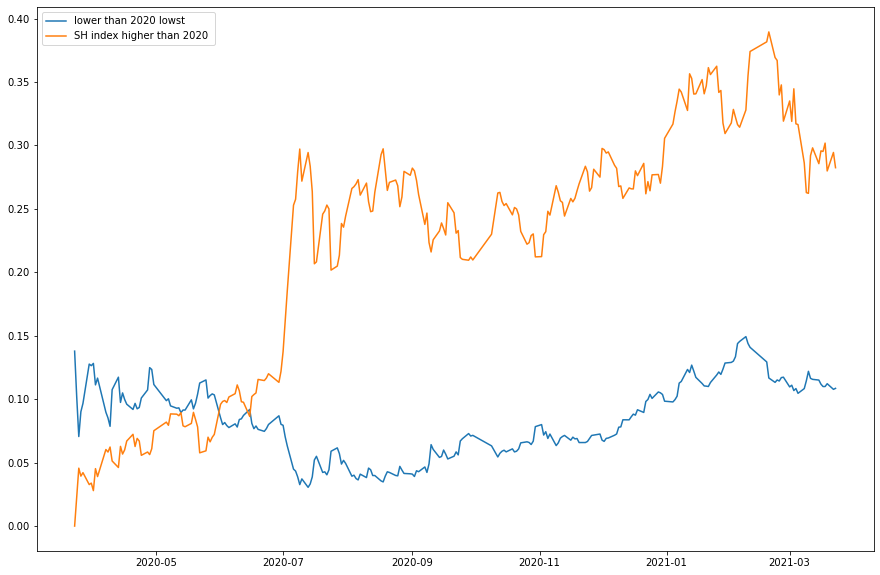

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)
ax.plot(dates, counts, label = "lower than 2020 lowst")
ax.plot(dates, index_precent, label = "SH index higher than 2020 ")
#ax.plot(dates, counts/index_precent)
ax.legend(loc = "best")
fig.savefig(results_path + end_day + '.jpg', transparent = False) # 保存图片

In [9]:
# 价格比 2 年都低的股票
date = ''
trade_cal = get_trade_calendar()
if date == '':
    date = datetime.now().date()
else:
    date = pd.to_datetime(date)
while trade_cal.loc[date.strftime('%Y-%m-%d')][0] == 0: # 去掉周末
    date = date - timedelta(days=1)
if date == datetime.now().date() and datetime.now().hour <= 17: # 当天的数据只能 17 点之后下载
    date = datetime.now().date() - timedelta(days=1)

lower_than_both = list_lower_than_both(date, old_price = 'close', now_price = 'close')
# 去掉 退市 和 ST
print(date.strftime('%Y-%m-%d'))
lower_than_both[ (~lower_than_both['name'].str.contains('ST')) & (~lower_than_both['name'].str.contains('退'))]

2021-03-23


,name,result_2019,result_2020
ts_code,,,
000005.SZ,世纪星源,-0.152727,-0.161871
000007.SZ,全新好,-0.482500,-0.496962
000008.SZ,神州高铁,-0.397961,-0.237708
000025.SZ,特力A,-0.146203,-0.108478
000031.SZ,大悦城,-0.157108,-0.205244
...,...,...,...
603929.SH,亚翔集成,-0.260753,-0.261690
603933.SH,睿能科技,-0.215528,-0.226251
603958.SH,哈森股份,-0.211228,-0.005625
